# Subclass OOD Setup

In [ ]:
import torch
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from pylab import rcParams

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

try:
  import cleanlab
except:
  !pip install cleanlab
  import cleanlab
from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues

import numpy as np 
import pandas as pd
import os
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot as plt
import requests
import zipfile
import shutil


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 11.7 MB/s 


In [ ]:
try:
  import timm
except:
  !pip install timm
  import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 13.7 MB/s 
     |████████████████████████████████| 182 kB 75.3 MB/s 


In [ ]:
# Continue with regular imports
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3297, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 3297 (delta 139), reused 230 (delta 110), pack-reused 3020
Receiving objects: 100% (3297/3297), 642.45 MiB | 28.82 MiB/s, done.
Resolving deltas: 100% (1869/1869), done.
Checking out files: 100% (221/221), done.


In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  train_path = '/content/drive/MyDrive/NNDL/Released_Data/train'
  test_path = '/content/drive/MyDrive/NNDL/Released_Data/test'  

except:
  train_path = '/content/train'
  test_path = '/content/test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dog = train_path + '/dog'
train_bird = train_path + '/bird'
train_rep = train_path + '/reptile' 

test_dog = test_path + '/dog'
test_bird = test_path + '/bird'
test_rep = test_path + '/reptile' 

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [ ]:
'''process below follows:
https://www.learnpytorch.io/06_pytorch_transfer_learning/'''

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

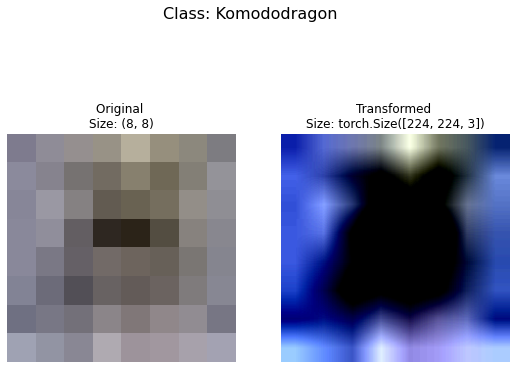

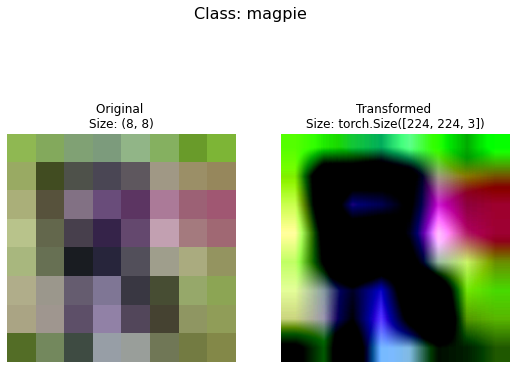

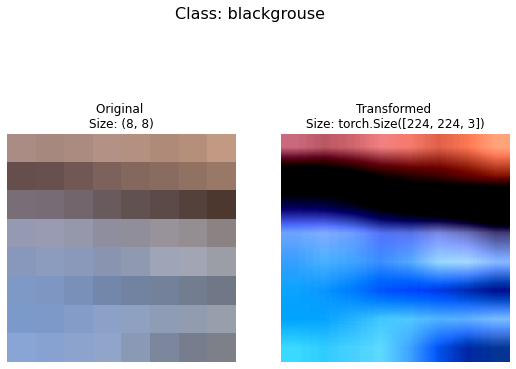

In [ ]:
#this returns a posix path to every image in our training directory 
image_paths = list(Path(train_path).glob("*/*/*.jpg"))

plot_transformed_images(image_paths, 
                        transform=manual_transforms, 
                        n=3)

In [ ]:
def imshow(img):
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset, show_labels=False):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X,y = dataset[i]
        ax = plt.subplot(3,5,i+1)
        if show_labels:
            ax.set_title(y)
        ax.imshow(imshow(X))
        ax.axis('off')
    plt.show()

def visualize_outliers(idxs, data):
    data_subset = torch.utils.data.Subset(data, idxs)
    plot_images(data_subset)

# Create Feature Embedding

In [ ]:
# Generates 2048-dimensional feature embeddings from images
def embed_images(model, dataloader):
    feature_embeddings = []
    for data in dataloader:
        images, labels = data
        with torch.no_grad():
            embeddings = model(images)
            feature_embeddings.extend(embeddings.numpy())
    feature_embeddings = np.array(feature_embeddings)
    return feature_embeddings  # each row corresponds to embedding of a different image

# Dog Subclass OOD

In [ ]:
transform_normalize = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),])
#train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
 #                                       download=True, transform=transform_normalize)
#test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=transform_normalize)
train_dog_dl, test_dog_dl, dog_classes = data_setup.create_dataloaders(
                                                            train_dir=train_dog,
                                                            test_dir=test_dog,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_dog_dl, test_dog_dl, dog_classes


(<torch.utils.data.dataloader.DataLoader at 0x7f43d5adc5b0>,
 ['Afghanhound',
  'Airedale',
  'Australianterrier',
  'Blenheimspaniel',
  'Bostonbull',
  'Chihuahua',
  'DandieDinmont',
  'Japanesespaniel',
  'Lakelandterrier',
  'Lhasa',
  'Maltesedog',
  'Pekinese',
  'Rhodesianridgeback',
  'Scotchterrier',
  'Sealyhamterrier',
  'Shih-Tzu',
  'Tibetanterrier',
  'WestHighlandwhiteterrier',
  'basset',
  'beagle',
  'bloodhound',
  'cairn',
  'giantschnauzer',
  'miniatureschnauzer',
  'papillon',
  'silkyterrier',
  'soft-coatedwheatenterrier',
  'standardschnauzer',
  'toyterrier'])

In [ ]:
# Load pretrained neural network
model = timm.create_model('resnet50', pretrained=True, num_classes=0)  # this is a pytorch network
model.eval()  # eval mode disables training-time operators (like batch normalization)

# Use dataloaders to stream images through the network
#batch_size = 50
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
#testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
trainloader = train_dog_dl
testloader = test_dog_dl 


# Generate feature embeddings
train_feature_embeddings = embed_images(model, trainloader)
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')
test_feature_embeddings = embed_images(model, testloader)
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


Train embeddings pooled shape: (2100, 2048)
Test embeddings pooled shape: (2100, 2048)


In [ ]:
train_data = datasets.ImageFolder(train_dog, transform=manual_transforms)

test_data = datasets.ImageFolder(test_dog, transform=manual_transforms)


In [ ]:
print(len(train_data))

2100


Fitting OOD estimator based on provided features ...


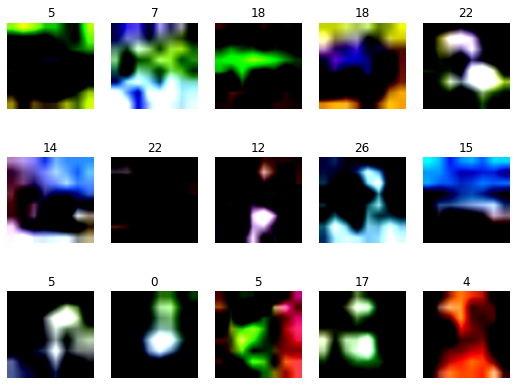

In [ ]:
dog_ood = OutOfDistribution()
train_ood_features_scores = dog_ood.fit_score(features=train_feature_embeddings)

top_train_ood_features_idxs = find_top_issues(quality_scores=train_ood_features_scores, top=15)
#TRAINING IMAGES MOST LIKELY TO BE CONSIDERED OOD
visualize_outliers(top_train_ood_features_idxs, train_data)

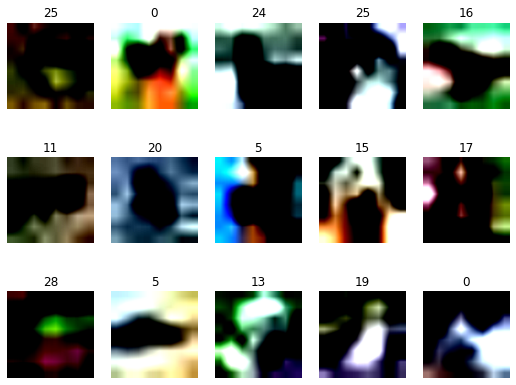

In [ ]:
bottom_train_ood_features_idxs = find_top_issues(quality_scores=-train_ood_features_scores, top=15)
#TRAINING IMAGES LEAST LIKELY TO BE OOD
visualize_outliers(bottom_train_ood_features_idxs, train_data)

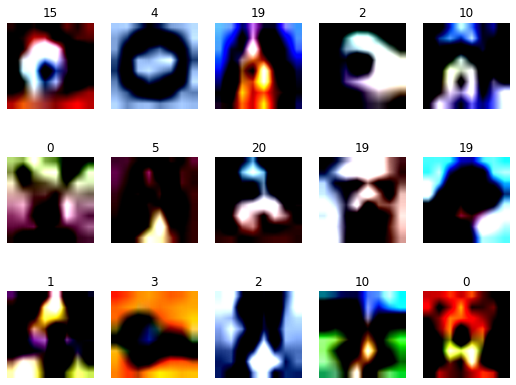

In [ ]:
test_ood_features_scores = dog_ood.score(features=test_feature_embeddings)

top_ood_features_idxs = find_top_issues(test_ood_features_scores, top=15)
#TEST IMAGES MOST LIKELY TO BE OOD
visualize_outliers(top_ood_features_idxs, test_data)

# Bird Subclass OOD

In [ ]:
transform_normalize = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),])
#train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
 #                                       download=True, transform=transform_normalize)
#test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=transform_normalize)
train_bird_dl, test_bird_dl, bird_classes = data_setup.create_dataloaders(
                                                            train_dir=train_bird,
                                                            test_dir=test_bird,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_bird_dl, test_bird_dl, bird_classes


(<torch.utils.data.dataloader.DataLoader at 0x7f43d28da6a0>,
 ['Americancoot',
  'Europeangallinule',
  'albatross',
  'baldeagle',
  'blackgrouse',
  'brambling',
  'bulbul',
  'bustard',
  'chickadee',
  'cock',
  'dowitcher',
  'goldfinch',
  'greatgreyowl',
  'hen',
  'housefinch',
  'indigobunting',
  'jay',
  'junco',
  'kingpenguin',
  'magpie',
  'ostrich',
  'oystercatcher',
  'pelican',
  'ptarmigan',
  'red-backedsandpiper',
  'redshank',
  'robin',
  'ruddyturnstone',
  'vulture',
  'waterouzel'])

In [ ]:
# Load pretrained neural network
model = timm.create_model('resnet50', pretrained=True, num_classes=0)  # this is a pytorch network
model.eval()  # eval mode disables training-time operators (like batch normalization)

# Use dataloaders to stream images through the network
#batch_size = 50
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
#testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
trainloader = train_bird_dl
testloader = test_bird_dl 


# Generate feature embeddings
train_feature_embeddings = embed_images(model, trainloader)
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')
test_feature_embeddings = embed_images(model, testloader)
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

Train embeddings pooled shape: (1922, 2048)
Test embeddings pooled shape: (1922, 2048)


In [ ]:
train_data = datasets.ImageFolder(train_bird, transform=manual_transforms)

test_data = datasets.ImageFolder(test_bird, transform=manual_transforms)


In [ ]:
print(len(train_data))

1922


Fitting OOD estimator based on provided features ...


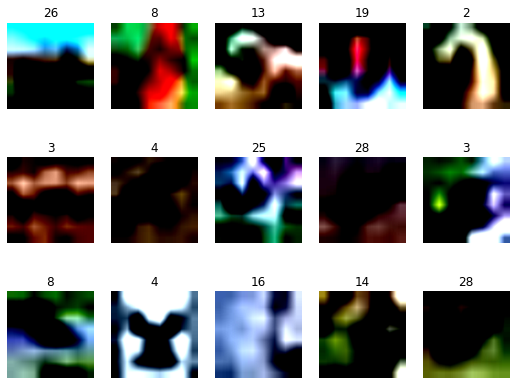

In [ ]:
bird_ood = OutOfDistribution()
train_ood_features_scores = bird_ood.fit_score(features=train_feature_embeddings)

top_train_ood_features_idxs = find_top_issues(quality_scores=train_ood_features_scores, top=15)
#TRAINING IMAGES MOST LIKELY TO BE CONSIDERED OOD
visualize_outliers(top_train_ood_features_idxs, train_data)

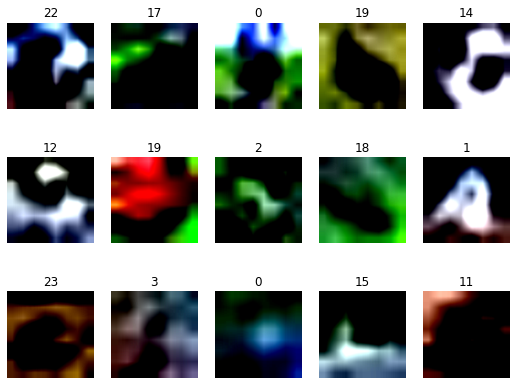

In [ ]:
bottom_train_ood_features_idxs = find_top_issues(quality_scores=-train_ood_features_scores, top=15)
#TRAINING IMAGES LEAST LIKELY TO BE OOD
visualize_outliers(bottom_train_ood_features_idxs, train_data)

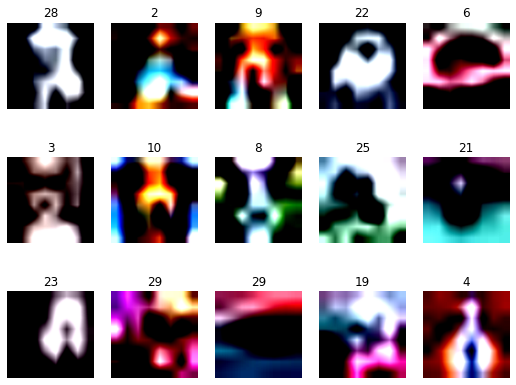

In [ ]:
test_ood_features_scores = bird_ood.score(features=test_feature_embeddings)

top_ood_features_idxs = find_top_issues(test_ood_features_scores, top=15)
#TEST IMAGES MOST LIKELY TO BE OOD
visualize_outliers(top_ood_features_idxs, test_data)

# Reptile Subclass OOD

In [ ]:
transform_normalize = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),])
#train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
 #                                       download=True, transform=transform_normalize)
#test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=transform_normalize)
train_rep_dl, test_rep_dl, rep_classes = data_setup.create_dataloaders(
                                                            train_dir=train_rep,
                                                            test_dir=test_rep,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_rep_dl, test_rep_dl, rep_classes


(<torch.utils.data.dataloader.DataLoader at 0x7f43d2865460>,
 ['Africanchameleon',
  'Africancrocodile',
  'Americanalligator',
  'Americanchameleon',
  'Europeanfiresalamander',
  'Gilamonster',
  'Komododragon',
  'agama',
  'alligatorlizard',
  'axolotl',
  'bandedgecko',
  'bullfrog',
  'commoniguana',
  'commonnewt',
  'eft',
  'frilledlizard',
  'greenlizard',
  'greensnake',
  'hognosesnake',
  'leatherbackturtle',
  'loggerhead',
  'mudturtle',
  'ringnecksnake',
  'spottedsalamander',
  'tailedfrog',
  'terrapin',
  'thundersnake',
  'treefrog',
  'triceratops',
  'whiptail'])

In [ ]:
# Load pretrained neural network
model = timm.create_model('resnet50', pretrained=True, num_classes=0)  # this is a pytorch network
model.eval()  # eval mode disables training-time operators (like batch normalization)

# Use dataloaders to stream images through the network
#batch_size = 50
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
#testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
trainloader = train_rep_dl
testloader = test_rep_dl 


# Generate feature embeddings
train_feature_embeddings = embed_images(model, trainloader)
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')
test_feature_embeddings = embed_images(model, testloader)
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

Train embeddings pooled shape: (2450, 2048)
Test embeddings pooled shape: (2450, 2048)


In [ ]:
train_data = datasets.ImageFolder(train_rep, transform=manual_transforms)

test_data = datasets.ImageFolder(test_rep, transform=manual_transforms)


In [ ]:
print(len(train_rep))

55


Fitting OOD estimator based on provided features ...


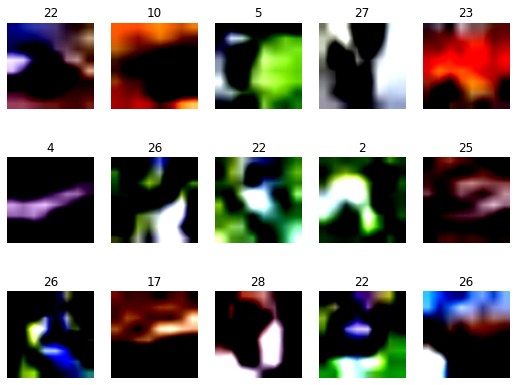

In [ ]:
rep_ood = OutOfDistribution()
train_ood_features_scores = rep_ood.fit_score(features=train_feature_embeddings)

top_train_ood_features_idxs = find_top_issues(quality_scores=train_ood_features_scores, top=15)
#TRAINING IMAGES MOST LIKELY TO BE CONSIDERED OOD
visualize_outliers(top_train_ood_features_idxs, train_data)

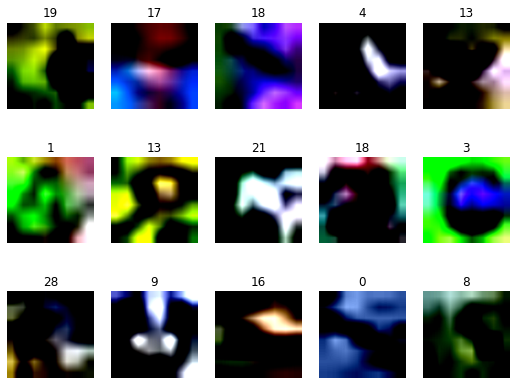

In [ ]:
bottom_train_ood_features_idxs = find_top_issues(quality_scores=-train_ood_features_scores, top=15)
#TRAINING IMAGES LEAST LIKELY TO BE OOD
visualize_outliers(bottom_train_ood_features_idxs, train_data)

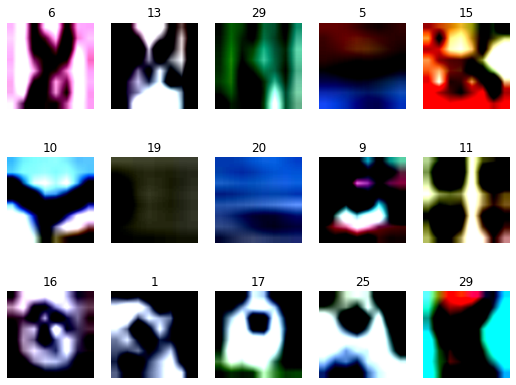

In [ ]:
test_ood_features_scores = dog_ood.score(features=test_feature_embeddings)

top_ood_features_idxs = find_top_issues(test_ood_features_scores, top=15)
#TEST IMAGES MOST LIKELY TO BE OOD
visualize_outliers(top_ood_features_idxs, test_data)

In [ ]:
#OOD Scores for test_rep
for x in test_ood_features_scores:
  print(x)

0.90752226
0.93551683
0.9175394
0.87603337
0.92622715
0.8610977
0.9131656
0.9078977
0.92723465
0.9368232
0.90468544
0.91092247
0.9103846
0.8900162
0.889698
0.9160804
0.89370656
0.9098789
0.9090471
0.88472396
0.9250607
0.9140716
0.9405306
0.8976947
0.8986063
0.91378486
0.9191161
0.88661385
0.9312643
0.90026367
0.9157586
0.94340014
0.93330777
0.9063891
0.8598724
0.9215638
0.9125166
0.9314715
0.93980044
0.92378294
0.86747444
0.8845757
0.926
0.8744219
0.8944302
0.8820133
0.92713195
0.91016954
0.86457694
0.8679293
0.9457286
0.9143116
0.8916841
0.9285107
0.9228336
0.8964729
0.86424476
0.9387882
0.84565336
0.91171306
0.9334641
0.85830456
0.88602686
0.85326916
0.94046474
0.9253325
0.91523427
0.9104562
0.8723384
0.8867117
0.9145729
0.87400395
0.87995756
0.87156147
0.9270235
0.8414646
0.9151779
0.9201212
0.8785289
0.9186639
0.85092074
0.90845364
0.8851135
0.9120562
0.87392896
0.92610204
0.9016306
0.88325846
0.904067
0.92599267
0.91838986
0.9233345
0.95407325
0.8820344
0.94611436
0.8889714
0.9271